# **Melakukan scraping data pada Trip.com**

In [ ]:
# Install library yang dibutuhkan
!pip install google-play-scraper
!pip install pandas numpy scikit-learn

In [21]:
# Import library
from google_play_scraper import Sort, reviews
import pandas as pd
import numpy as np

In [52]:
# Scraping data ulasan
review, continuation_token = reviews(
    'ctrip.english',                    # ID aplikasi Trip.com
    lang='id',                          # Bahasa ulasan (Indonesia)
    country='id',                       # Negara
    sort=Sort.MOST_RELEVANT,            # Sortir berdasarkan relevansi
    count=1000                           # Jumlah ulasan yang ingin diambil
)

In [53]:
# Simpan data dalam DataFrame
comments = pd.DataFrame(review)
comments

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,95c616d8-c761-4f44-b616-49f3fc25e2bd,Agus Ropiudin,https://play-lh.googleusercontent.com/a/ACg8oc...,Saya kasih bintang 2 dlu .boleh diinfo cara Re...,2,5,8.16.0,2024-12-11 11:07:17,Kami mohon maaf atas ketidaknyamanan Anda. Per...,2024-12-11 11:12:02,8.16.0
1,5cffd73d-a866-46fe-9926-9c566b7cb567,Wulan Ulaa,https://play-lh.googleusercontent.com/a-/ALV-U...,"Sangat buruk , kamar tiba"" berubah type padaha...",1,25,8.12.0,2024-10-09 15:49:43,"Hai, Wulan Ulaa. Kami menyayangkan atas pengal...",2024-10-09 15:54:08,8.12.0
2,af6700a8-a523-4b43-b7d6-fc9bc63d636c,Abdul Rohman,https://play-lh.googleusercontent.com/a-/ALV-U...,"Indonesia banyak wisatawan manca negara, karen...",5,3,8.16.0,2024-12-15 23:59:22,Kami sangat menghargai Anda telah meluangkan w...,2024-12-16 00:01:34,8.16.0
3,4434c4a1-eda2-4a82-b8f3-676a9ff458be,Yunike D,https://play-lh.googleusercontent.com/a-/ALV-U...,Beberapa kali pesan hotel mendapatkan harga te...,4,7,8.16.0,2024-12-07 00:26:30,"Halo Yunike D, kami sangat senang mendengar An...",2024-12-07 00:48:32,8.16.0
4,9f888d20-b0b0-42d1-bc38-7db48c756761,Ronan Ferry,https://play-lh.googleusercontent.com/a-/ALV-U...,"Bookingan saya tiba tiba di cancel, sudah paym...",1,26,8.12.0,2024-10-08 19:43:10,Kami mohon maaf atas ketidaknyamanan Anda. Per...,2024-10-08 19:51:40,8.12.0
...,...,...,...,...,...,...,...,...,...,...,...
995,599ee5d4-fe53-4537-a810-455ee619a8b6,muhammad arwani,https://play-lh.googleusercontent.com/a-/ALV-U...,Aplikasinya simple yang sangat mwmbantu,5,0,7.87.2,2023-10-28 15:08:38,Kami sangat menghargai Anda telah meluangkan w...,2023-10-28 15:39:40,7.87.2
996,108e67ee-eef9-45ce-89a8-1b9070a18af8,Aji Herex,https://play-lh.googleusercontent.com/a/ACg8oc...,Sangat membantu buat beli tiket gk ribet,5,0,7.80.2,2023-07-31 14:13:33,Dear Aji Herex. Terima kasih telah membagi ula...,2023-07-31 14:28:02,7.80.2
997,fe51a7a9-1fb3-49bf-a52f-5d57070631db,nakee qu,https://play-lh.googleusercontent.com/a-/ALV-U...,lebih simple cek harga termurah,5,0,7.85.0,2023-09-19 03:18:24,Kami sangat menghargai Anda telah meluangkan w...,2023-09-19 03:31:18,7.85.0
998,0e67697d-b6b7-4435-bf32-8e72c57c4708,19-0242 Surya islami,https://play-lh.googleusercontent.com/a/ACg8oc...,Sangat bermanfaat untuk traveling,5,0,None,2023-09-22 16:15:58,Dear 19-0242 Surya islami. Terima kasih telah ...,2023-09-22 16:29:41,None


In [54]:
# Simpan ke CSV
comments.to_csv('tripcom-review.csv', index=False)

# ***Exploratory Data Analysis* (EDA)**

In [55]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# Informasi umum tentang dataset
comments.info()

# Cek jumlah nilai yang hilang (missing values)
comments.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1000 non-null   object        
 1   userName              1000 non-null   object        
 2   userImage             1000 non-null   object        
 3   content               1000 non-null   object        
 4   score                 1000 non-null   int64         
 5   thumbsUpCount         1000 non-null   int64         
 6   reviewCreatedVersion  839 non-null    object        
 7   at                    1000 non-null   datetime64[ns]
 8   replyContent          948 non-null    object        
 9   repliedAt             948 non-null    datetime64[ns]
 10  appVersion            839 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 86.1+ KB


reviewId                  0
userName                  0
userImage                 0
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion    161
at                        0
replyContent             52
repliedAt                52
appVersion              161
dtype: int64

C:\Users\alfia\AppData\Local\Temp\ipykernel_10068\516753496.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=comments, palette='viridis')


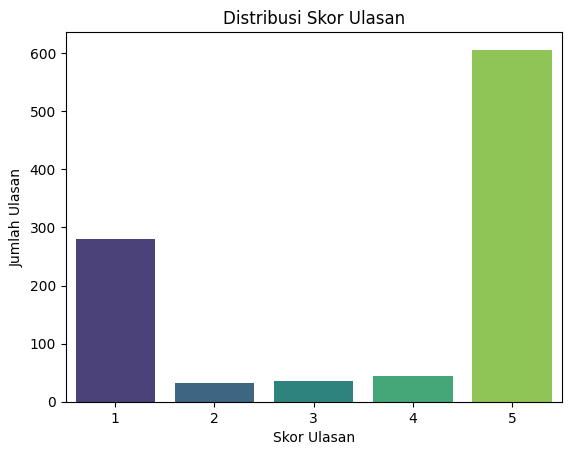

In [57]:
# Distribusi skor ulasan
sns.countplot(x='score', data=comments, palette='viridis')
plt.title('Distribusi Skor Ulasan')
plt.xlabel('Skor Ulasan')
plt.ylabel('Jumlah Ulasan')
plt.show()

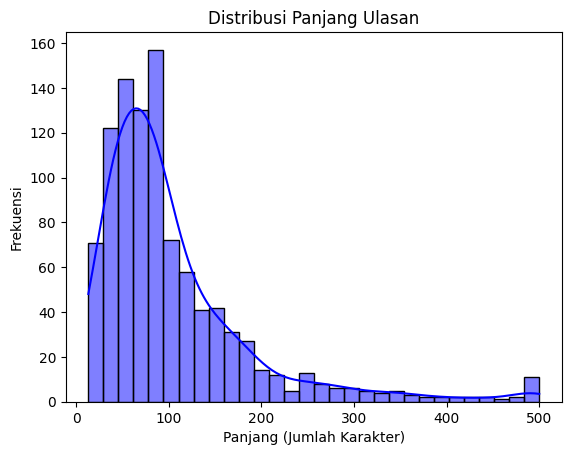

In [59]:
# Tambahkan kolom jumlah karakter pada setiap ulasan
comments['content_length'] = comments['content'].apply(len)

# Visualisasi distribusi panjang konten ulasan
sns.histplot(comments['content_length'], bins=30, kde=True, color='blue')
plt.title('Distribusi Panjang Ulasan')
plt.xlabel('Panjang (Jumlah Karakter)')
plt.ylabel('Frekuensi')
plt.show()


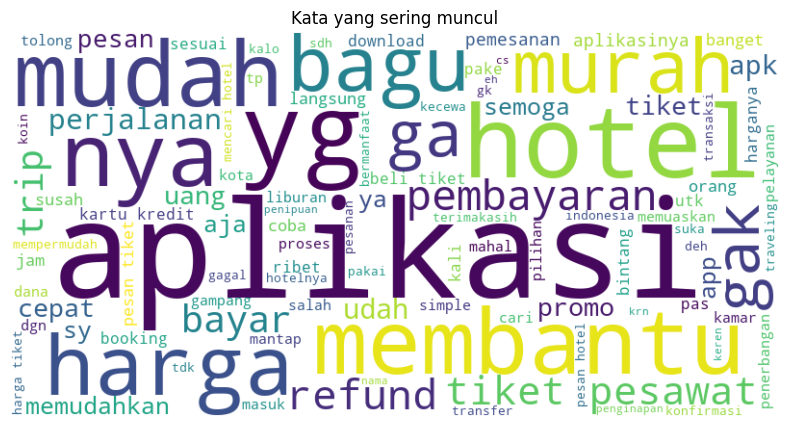

In [60]:
# Import library tambahan
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords

# Bersihkan teks (hilangkan simbol, angka, dll.)
def clean_text(text):
    text = re.sub(r'[^A-Za-z\s]', '', text) # Hapus karakter non-huruf
    text = text.lower()                     # Ubah ke huruf kecil
    return text

# Terapkan pembersihan pada kolom 'content'
comments['cleaned_content'] = comments['content'].apply(clean_text)

# Gabungkan semua ulasan menjadi satu string
all_words = ' '.join([text for text in comments['cleaned_content']])

# Buat WordCloud
wordcloud = WordCloud(stopwords=set(stopwords.words('indonesian')),
                      background_color='white',
                      max_words=100,
                      width=800,
                      height=400).generate(all_words)

# Visualisasikan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Kata yang sering muncul')
plt.show()


C:\Users\alfia\AppData\Local\Temp\ipykernel_10068\971368348.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimen', data=comments, palette='pastel')


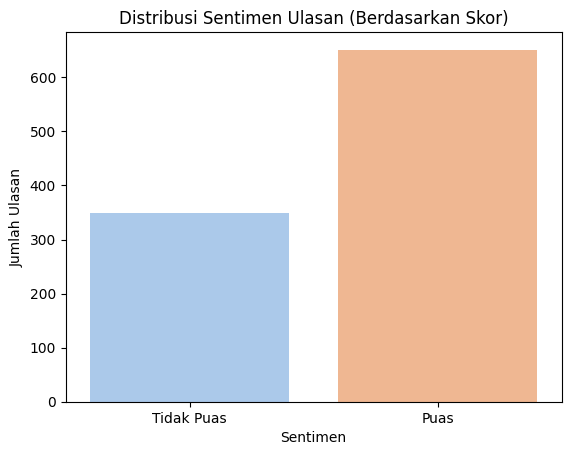

In [61]:
# Visualisasi jumlah ulasan yang puas dan tidak puas (berdasarkan skor)
comments['sentimen'] = np.where(comments['score'] >= 4, 'Puas', 'Tidak Puas')

# Visualisasi distribusi sentimen
sns.countplot(x='sentimen', data=comments, palette='pastel')
plt.title('Distribusi Sentimen Ulasan (Berdasarkan Skor)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()

# **Cleaning Data**

In [62]:
import re

# Hapus kolom yang tidak diperlukan
comments_cleaned = comments[['content', 'score']]  # Hanya ambil kolom 'content' dan 'Skor'

# Hapus komentar yang kosong
comments_cleaned = comments_cleaned.dropna(subset=['content', 'score'])

# Menghapus karakter khusus (tanda baca), angka, dan URL
comments_cleaned['content'] = comments_cleaned['content'].apply(lambda x: re.sub(r'http\S+|www\S+|\S+@\S+', '', x))  # Hapus URL
comments_cleaned['content'] = comments_cleaned['content'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))  # Hapus karakter selain huruf

# Hapus komentar yang kosong
comments_cleaned = comments_cleaned.dropna(subset=['content'])

# Tampilkan beberapa contoh setelah data cleaning
comments_cleaned.head()

,content,score
0,Saya kasih bintang dlu boleh diinfo cara Resc...,2
1,Sangat buruk kamar tiba berubah type padahal ...,1
2,Indonesia banyak wisatawan manca negara karena...,5
3,Beberapa kali pesan hotel mendapatkan harga te...,4
4,Bookingan saya tiba tiba di cancel sudah payme...,1


# **Case Folding**

In [63]:

# Terapkan case folding untuk mengubah semua teks menjadi huruf kecil
comments_cleaned['content'] = comments_cleaned['content'].str.lower()

# Tampilkan beberapa contoh setelah case folding
comments_cleaned.head()

,content,score
0,saya kasih bintang dlu boleh diinfo cara resc...,2
1,sangat buruk kamar tiba berubah type padahal ...,1
2,indonesia banyak wisatawan manca negara karena...,5
3,beberapa kali pesan hotel mendapatkan harga te...,4
4,bookingan saya tiba tiba di cancel sudah payme...,1


# **Penghapusan STOPWORD**

In [64]:
import nltk
from nltk.tokenize import word_tokenize  # Impor word_tokenize
from nltk.corpus import stopwords  # Impor stopwords
nltk.data.clear_cache()
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alfia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alfia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alfia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [67]:
# Hapus Stopwords (Hapus Kata-kata Umum)
try:
    stop_words = set(stopwords.words('indonesian'))  # Daftar stopwords bahasa Indonesia
except OSError:
    print("Stopwords bahasa Indonesia tidak tersedia di NLTK. Gunakan pustaka Sastrawi atau masukkan stopwords secara manual.")
    stop_words = set()  # Jika tidak ada stopwords Indonesia, gunakan set kosong

comments_cleaned['tokens_no_stopwords'] = comments_cleaned['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])  # Hapus stopwords

comments_cleaned.head()

,content,score,tokens,tokens_no_stopwords
0,saya kasih bintang dlu boleh diinfo cara resc...,2,"[saya, kasih, bintang, dlu, boleh, diinfo, car...","[kasih, bintang, dlu, diinfo, reschedule, pene..."
1,sangat buruk kamar tiba berubah type padahal ...,1,"[sangat, buruk, kamar, tiba, berubah, type, pa...","[buruk, kamar, berubah, type, udah, payment, p..."
2,indonesia banyak wisatawan manca negara karena...,5,"[indonesia, banyak, wisatawan, manca, negara, ...","[indonesia, wisatawan, manca, negara, terkenal..."
3,beberapa kali pesan hotel mendapatkan harga te...,4,"[beberapa, kali, pesan, hotel, mendapatkan, ha...","[kali, pesan, hotel, harga, termurah, aplikasi..."
4,bookingan saya tiba tiba di cancel sudah payme...,1,"[bookingan, saya, tiba, tiba, di, cancel, suda...","[bookingan, cancel, payment, lumayan, dimohon,..."


# **TOKENISASI**

In [66]:
# Tokenisasi (Pisahkan Teks menjadi Daftar Kata)
comments_cleaned['tokens'] = comments_cleaned['content'].apply(word_tokenize)
comments_cleaned.head()

,content,score,tokens
0,saya kasih bintang dlu boleh diinfo cara resc...,2,"[saya, kasih, bintang, dlu, boleh, diinfo, car..."
1,sangat buruk kamar tiba berubah type padahal ...,1,"[sangat, buruk, kamar, tiba, berubah, type, pa..."
2,indonesia banyak wisatawan manca negara karena...,5,"[indonesia, banyak, wisatawan, manca, negara, ..."
3,beberapa kali pesan hotel mendapatkan harga te...,4,"[beberapa, kali, pesan, hotel, mendapatkan, ha..."
4,bookingan saya tiba tiba di cancel sudah payme...,1,"[bookingan, saya, tiba, tiba, di, cancel, suda..."


# **STEMMING**

In [68]:
#Stemming data
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Inisialisasi Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

comments_cleaned['stemmed_tokens'] = comments_cleaned['tokens_no_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])

comments_cleaned.head()

Defaulting to user installation because normal site-packages is not writeable


,content,score,tokens,tokens_no_stopwords,stemmed_tokens
0,saya kasih bintang dlu boleh diinfo cara resc...,2,"[saya, kasih, bintang, dlu, boleh, diinfo, car...","[kasih, bintang, dlu, diinfo, reschedule, pene...","[kasih, bintang, dlu, info, reschedule, terban..."
1,sangat buruk kamar tiba berubah type padahal ...,1,"[sangat, buruk, kamar, tiba, berubah, type, pa...","[buruk, kamar, berubah, type, udah, payment, p...","[buruk, kamar, ubah, type, udah, payment, pros..."
2,indonesia banyak wisatawan manca negara karena...,5,"[indonesia, banyak, wisatawan, manca, negara, ...","[indonesia, wisatawan, manca, negara, terkenal...","[indonesia, wisatawan, manca, negara, kenal, r..."
3,beberapa kali pesan hotel mendapatkan harga te...,4,"[beberapa, kali, pesan, hotel, mendapatkan, ha...","[kali, pesan, hotel, harga, termurah, aplikasi...","[kali, pesan, hotel, harga, murah, aplikasi, m..."
4,bookingan saya tiba tiba di cancel sudah payme...,1,"[bookingan, saya, tiba, tiba, di, cancel, suda...","[bookingan, cancel, payment, lumayan, dimohon,...","[bookingan, cancel, payment, lumayan, mohon, r..."


# **LABELING**

In [69]:
#Pelabelan
def label_based_on_score(score):
    """Buat label puas atau tidak puas berdasarkan skor ulasan."""
    if score >= 4:
        return 1  # Puas
    elif score <= 3:
        return 0  # Tidak Puas

comments_cleaned['sentiment_label'] = comments_cleaned['score'].apply(label_based_on_score)

# comments_cleaned['sentiment'] = comments_cleaned['content'].apply(label_sentiment)
comments_cleaned.head()

,content,score,tokens,tokens_no_stopwords,stemmed_tokens,sentiment_label
0,saya kasih bintang dlu boleh diinfo cara resc...,2,"[saya, kasih, bintang, dlu, boleh, diinfo, car...","[kasih, bintang, dlu, diinfo, reschedule, pene...","[kasih, bintang, dlu, info, reschedule, terban...",0
1,sangat buruk kamar tiba berubah type padahal ...,1,"[sangat, buruk, kamar, tiba, berubah, type, pa...","[buruk, kamar, berubah, type, udah, payment, p...","[buruk, kamar, ubah, type, udah, payment, pros...",0
2,indonesia banyak wisatawan manca negara karena...,5,"[indonesia, banyak, wisatawan, manca, negara, ...","[indonesia, wisatawan, manca, negara, terkenal...","[indonesia, wisatawan, manca, negara, kenal, r...",1
3,beberapa kali pesan hotel mendapatkan harga te...,4,"[beberapa, kali, pesan, hotel, mendapatkan, ha...","[kali, pesan, hotel, harga, termurah, aplikasi...","[kali, pesan, hotel, harga, murah, aplikasi, m...",1
4,bookingan saya tiba tiba di cancel sudah payme...,1,"[bookingan, saya, tiba, tiba, di, cancel, suda...","[bookingan, cancel, payment, lumayan, dimohon,...","[bookingan, cancel, payment, lumayan, mohon, r...",0


In [70]:
#Simpan ke CSV
comments_cleaned.to_csv('cleaned_comments_tripcom.csv', index=False)

# **VECTORISASI**

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer


# TF-IDF Vectorizer (Ubah teks ke dalam bentuk vektor numerik)
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(comments_cleaned['content'])  # Fitur (X)
y = comments_cleaned['sentiment_label']  # Label (y)

#Fitur(Kata-kata unik) dari TF-IDF
tfidf_vectorizer.get_feature_names_out()


array(['aamiin', 'abal', 'abang', ..., 'zaman', 'zhai', 'zoonkkk'],
      dtype=object)

In [72]:
tfidf_matrix = X.toarray()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head(10)
# tfidf_df.to_csv('tfidf_matrix.csv', index=False)

,aamiin,abal,abang,abis,acara,acc,accord,account,acctolong,acoba,...,yahlumayan,yahmint,yak,yang,yg,yng,you,zaman,zhai,zoonkkk
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.065306,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.065151,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.123921,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.17095,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.137008,0.068192,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.414793,0.000000,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


# **SPLITTING DATA**

In [75]:
#Skenario 1# data latih (80%) dan data uji (20%)

from sklearn.model_selection import train_test_split

# Memisahkan fitur dan target
X = comments_cleaned['content']  # Ulasan yang akan dianalisis
y = comments_cleaned['sentiment_label']  # Sentimen yang sudah dilabeli

# Membagi data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menampilkan bentuk data latih dan data uji
print("Data Latih:", X_train.shape)
print("Data Uji:", X_test.shape)

Data Latih: (800,)
Data Uji: (200,)


In [73]:
#Skenario 2# data latih (60%) dan data uji (40%)

from sklearn.model_selection import train_test_split

# Memisahkan fitur dan target
X = comments_cleaned['content']  # Ulasan yang akan dianalisis
y = comments_cleaned['sentiment_label']  # Sentimen yang sudah dilabeli

# Membagi data menjadi data latih (60%) dan data uji (40%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Menampilkan bentuk data latih dan data uji
print("Data Latih:", X_train.shape)
print("Data Uji:", X_test.shape)

Data Latih: (600,)
Data Uji: (400,)


# **UJI MODEL**

**DecissionTree**

In [80]:
#DecisionTree

import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model Decision Tree
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_tfidf, y_train)

# Prediksi dan evaluasi
y_pred_dt = model_dt.predict(X_test_tfidf)
print("Decision Tree - Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Decision Tree - Classification Report:\n", classification_report(y_test, y_pred_dt))

# Simpan Model dan TF-IDF ke File
joblib.dump(model_dt, 'decision_tree_model.pkl')  # Menyimpan model Decision Tree
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')  # Menyimpan vektorisator
print("Model Decision Tree dan TF-IDF berhasil disimpan!")


Decision Tree - Accuracy: 0.85
Decision Tree - Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79        69
           1       0.90      0.87      0.88       131

    accuracy                           0.85       200
   macro avg       0.83      0.84      0.84       200
weighted avg       0.85      0.85      0.85       200

Model Decision Tree dan TF-IDF berhasil disimpan!


**Logistic**

In [81]:
#Logistic

import joblib
from sklearn.linear_model import LogisticRegression  # Import Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model Logistic Regression
model_lr = LogisticRegression()  # Menggunakan Logistic Regression
model_lr.fit(X_train_tfidf, y_train)

# Prediksi dan evaluasi
y_pred_lr = model_lr.predict(X_test_tfidf)
print("Logistic Regression - Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression - Classification Report:\n", classification_report(y_test, y_pred_lr))

# Simpan Model dan TF-IDF ke File
joblib.dump(model_lr, 'logistic_model.pkl')  # Menyimpan model Logistic Regression
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')  # Menyimpan vektorisator
print("Model Logistic Regression dan TF-IDF berhasil disimpan!")

Logistic Regression - Accuracy: 0.9
Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.81      0.85        69
           1       0.91      0.95      0.93       131

    accuracy                           0.90       200
   macro avg       0.90      0.88      0.89       200
weighted avg       0.90      0.90      0.90       200

Model Logistic Regression dan TF-IDF berhasil disimpan!


**RandomForest**

In [82]:
import joblib
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Menggunakan Random Forest
model_rf.fit(X_train_tfidf, y_train)

# Prediksi dan evaluasi
y_pred_rf = model_rf.predict(X_test_tfidf)
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest - Classification Report:\n", classification_report(y_test, y_pred_rf))

# Simpan Model dan TF-IDF ke File
joblib.dump(model_rf, 'random_forest_model.pkl')  # Menyimpan model Random Forest
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')  # Menyimpan vektorisator
print("Model Random Forest dan TF-IDF berhasil disimpan!")

Random Forest - Accuracy: 0.9
Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85        69
           1       0.90      0.95      0.93       131

    accuracy                           0.90       200
   macro avg       0.90      0.88      0.89       200
weighted avg       0.90      0.90      0.90       200

Model Random Forest dan TF-IDF berhasil disimpan!


**Naive Bayes**

In [83]:
import joblib
from sklearn.naive_bayes import MultinomialNB  # Import Multinomial Naive Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model Naive Bayes
model_nb = MultinomialNB()  # Menggunakan Naive Bayes
model_nb.fit(X_train_tfidf, y_train)

# Prediksi dan evaluasi
y_pred_nb = model_nb.predict(X_test_tfidf)
print("Naive Bayes - Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes - Classification Report:\n", classification_report(y_test, y_pred_nb))

# Simpan Model dan TF-IDF ke File
joblib.dump(model_nb, 'naive_bayes_model.pkl')  # Menyimpan model Naive Bayes
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')  # Menyimpan vektorisator
print("Model Naive Bayes dan TF-IDF berhasil disimpan!")


Naive Bayes - Accuracy: 0.88
Naive Bayes - Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.71      0.80        69
           1       0.86      0.97      0.91       131

    accuracy                           0.88       200
   macro avg       0.89      0.84      0.86       200
weighted avg       0.88      0.88      0.88       200

Model Naive Bayes dan TF-IDF berhasil disimpan!


# **DEPLOYMENT TO STREAMLIT**

In [ ]:
!pip install streamlit

In [86]:
%%writefile app.py
import streamlit as st
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import TfidfVectorizer  # Gunakan TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from google_play_scraper import reviews, Sort
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import nltk
import io

# Download data nltk
nltk.download('punkt')
nltk.download('stopwords')

# Memuat model dan vektorisator
model_nb = joblib.load('naive_bayes_model.pkl')  # Model Naive Bayes
model_rf = joblib.load('random_forest_model.pkl')  # Model Random Forest
model_lr = joblib.load('logistic_model.pkl')  # Model Logistic Regression
vectorizer = joblib.load('tfidf_vectorizer.pkl')  # Memuat vektorisator yang sesuai


def predict_sentiment(text, model):
    # Mengubah teks input menjadi fitur numerik menggunakan TF-IDF
    text_tfidf = vectorizer.transform([text])
    # Prediksi sentimen menggunakan model yang dipilih
    sentiment = model.predict(text_tfidf)[0]
    return sentiment

# Fungsi pembersihan teks
def clean_text(text):
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Hapus karakter non-huruf
    text = text.lower()  # Ubah ke huruf kecil
    return text

# Fungsi EDA
def perform_eda(data):
    st.subheader('1. Informasi Data')
    st.write("### **Head Data**")
    st.write(data.head())
    st.write(f"**Jumlah Data:** {data.shape[0]}")
    st.write(f"**Jumlah Kolom:** {data.shape[1]}")

    # Menampilkan info data
    buffer = io.StringIO()
    data.info(buf=buffer)
    s = buffer.getvalue()
    st.text(s)

    st.subheader('2. Distribusi Skor Ulasan')
    fig, ax = plt.subplots()
    sns.countplot(x='score', data=data, palette='viridis', ax=ax)
    ax.set_title("Distribusi Skor Ulasan")
    st.pyplot(fig)

    st.subheader('3. Distribusi Panjang Ulasan')
    data['content_length'] = data['content'].apply(len)
    fig, ax = plt.subplots()
    sns.histplot(data['content_length'], bins=30, kde=True, color='blue', ax=ax)
    ax.set_title("Distribusi Panjang Ulasan")
    st.pyplot(fig)

    st.subheader('4. WordCloud Kata Dominan')
    all_words = ' '.join([clean_text(text) for text in data['content']])
    wordcloud = WordCloud(
        stopwords=set(stopwords.words('indonesian')),
        background_color='white',
        width=800,
        height=400
    ).generate(all_words)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title("WordCloud Kata Dominan")
    st.pyplot(fig)

# Inisialisasi Stemmer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi Pembersihan Data
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|\S+@\S+', '', text)  # Hapus URL dan email
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Hapus karakter selain huruf
    text = text.lower()  # Ubah ke huruf kecil
    return text

# Fungsi Tokenisasi
def tokenize_text(text):
    return word_tokenize(text)

# Fungsi untuk Hapus Stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('indonesian'))
    return [word for word in tokens if word.lower() not in stop_words]

# Fungsi untuk Stemming
def stem_tokens(tokens):
    return [stemmer.stem(word) for word in tokens]

# Fungsi untuk Memberikan Label Sentimen
def label_based_on_score(score):
    if score >= 4:
        return 1  # Puas
    elif score <= 3:
        return 0  # Tidak Puas

# Fungsi Preprocessing
def preprocess_data(data):
    if 'content' in data.columns and 'score' in data.columns:
        comments_cleaned = data[['content', 'score']].copy()
    else:
        st.error("File CSV harus memiliki kolom 'content' dan 'score'.")
        return None

    comments_cleaned = comments_cleaned.dropna(subset=['content', 'score'])

    comments_cleaned['content'] = comments_cleaned['content'].apply(clean_text)
    comments_cleaned['tokens'] = comments_cleaned['content'].apply(tokenize_text)
    comments_cleaned['tokens_no_stopwords'] = comments_cleaned['tokens'].apply(remove_stopwords)
    comments_cleaned['stemmed_tokens'] = comments_cleaned['tokens_no_stopwords'].apply(stem_tokens)
    comments_cleaned['sentiment_label'] = comments_cleaned['score'].apply(label_based_on_score)

    tfidf_vectorizer = TfidfVectorizer()
    X = tfidf_vectorizer.fit_transform(comments_cleaned['content'])  # Fitur (X)
    y = comments_cleaned['sentiment_label']  # Label (y)

    tfidf_matrix = X.toarray()
    tfidf_df = pd.DataFrame(tfidf_matrix, columns=tfidf_vectorizer.get_feature_names_out())

    return comments_cleaned, tfidf_df

# Fungsi untuk Split Data, Latih Model, dan Evaluasi
def train_and_evaluate_model(data):
    X = data['content']
    y = data['sentiment_label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    model_nb = MultinomialNB()
    model_nb.fit(X_train_tfidf, y_train)
    y_pred_nb = model_nb.predict(X_test_tfidf)
    acc_nb = accuracy_score(y_test, y_pred_nb)
    report_nb = classification_report(y_test, y_pred_nb)
    joblib.dump(model_nb, 'naive_bayes_model.pkl')

    model_lr = LogisticRegression(max_iter=1000)
    model_lr.fit(X_train_tfidf, y_train)
    y_pred_lr = model_lr.predict(X_test_tfidf)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    report_lr = classification_report(y_test, y_pred_lr)
    joblib.dump(model_lr, 'logistic_regression_model.pkl')

    model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    model_rf.fit(X_train_tfidf, y_train)
    y_pred_rf = model_rf.predict(X_test_tfidf)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    report_rf = classification_report(y_test, y_pred_rf)
    joblib.dump(model_rf, 'random_forest_model.pkl')

    joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

    return {
        'Naive Bayes': {'accuracy': acc_nb, 'report': report_nb},
        'Logistic Regression': {'accuracy': acc_lr, 'report': report_lr},
        'Random Forest': {'accuracy': acc_rf, 'report': report_rf}
    }

# Streamlit App Layout
st.title('Sentiment Analysis & EDA')
st.write("Masukkan ulasan untuk menganalisis sentimen atau unggah file CSV untuk melakukan EDA.")

# Tab Navigasi
tab1, tab2, tab3, tab4, tab5 = st.tabs(["📊 EDA", "📈 Prediksi Sentimen", "Scapping", "Preprocessing Data", "Training"])

# Tab 1: EDA
with tab1:
    st.header('📊 Eksplorasi Data Ulasan (EDA)')
    uploaded_file = st.file_uploader("Unggah file CSV untuk EDA", type=["csv"])

    if uploaded_file is not None:
        data = pd.read_csv(uploaded_file)
        if 'content' in data.columns and 'score' in data.columns:
            perform_eda(data[['content', 'score']])
        else:
            st.error("File CSV harus memiliki kolom 'content' dan 'score'.")
    else:
        st.write("Unggah file CSV untuk memulai EDA.")

# Tab 2: Prediksi Sentimen
with tab2:
    st.header('📈 Prediksi Sentimen')
    # Pilihan model di Streamlit
    model_choice = st.selectbox(
        'Pilih Model untuk Prediksi Sentimen:',
        ['Naive Bayes', 'Random Forest', 'Logistic Regression']
    )

    # Menentukan model yang dipilih
    if model_choice == 'Naive Bayes':
        selected_model = model_nb
    elif model_choice == 'Random Forest':
        selected_model = model_rf
    else:
        selected_model = model_lr
        
    user_input = st.text_area("Masukkan teks ulasan")

    # Jika pengguna mengklik tombol, tampilkan prediksi
    if st.button('Prediksi Sentimen'):
        if user_input:
            sentiment = predict_sentiment(user_input, selected_model)
            if sentiment == 1:
                st.success("Sentimen: **Puas** 😄")
            else:
                st.error("Sentimen: **Tidak Puas** 😞")
        else:
            st.warning("Tolong masukkan teks untuk analisis.")

# Tab 3: Scraping
with tab3:
    st.header("Scraping Ulasan Google Play Store")
    app_id = st.text_input("Masukkan ID Aplikasi Google Play", 'ctrip.english')
    jumlah_ulasan = st.number_input("Jumlah ulasan yang ingin diambil", min_value=10, max_value=1000, value=300, step=10)

    if st.button('Scrape Data Ulasan'):
        if app_id:
            with st.spinner('Mengambil ulasan dari Google Play Store...'):
                try:
                    review, _ = reviews(
                        app_id=app_id,
                        lang='id',
                        country='id',
                        count=int(jumlah_ulasan),
                        sort=Sort.MOST_RELEVANT
                    )
                    if isinstance(review, str):
                        st.error(f"Terjadi kesalahan saat scraping: {review}")
                    else:
                        data = pd.DataFrame(review)
                        st.success(f"Berhasil mengambil ulasan dari Google Play Store!")
                        st.write("📋 **Tampilan Data**")
                        st.dataframe(data.head(10))

                        st.download_button(
                            label="📁 Unduh Data Ulasan Sebagai CSV",
                            data=data.to_csv(index=False),
                            file_name='ulasan_google_play.csv',
                            mime='text/csv',
                        )

                        st.session_state['scraped_data'] = data

                except Exception as e:
                    st.error(f"Terjadi kesalahan saat scraping: {e}")
        else:
            st.error("Masukkan ID aplikasi Google Play.")

# Tab 4: Preprocessing Data
with tab4:
    st.header("Preprocessing Data")
    uploaded_file = st.file_uploader("Unggah file CSV untuk Preprocessing", type=["csv"])

    if uploaded_file is not None:
        data = pd.read_csv(uploaded_file)
        st.write("📋 **Preview Data Sebelum Preprocessing**")
        st.dataframe(data.head(10))

        if st.button('Mulai Preprocessing'):
            with st.spinner('Proses preprocessing sedang berjalan...'):
                preprocessed_data, tfidf_df = preprocess_data(data)
                if preprocessed_data is not None:
                    st.success('Preprocessing selesai!')
                    st.write("📋 **Preview Data Setelah Preprocessing**")
                    st.dataframe(preprocessed_data.head(10))

                    csv_file = preprocessed_data.to_csv(index=False)
                    st.download_button(
                        label="📁 Unduh Data Preprocessed Sebagai CSV",
                        data=csv_file,
                        file_name='preprocessed_comments.csv',
                        mime='text/csv',
                    )

                    st.write("📋 **Matriks TF-IDF (10 Baris Pertama)**")
                    st.dataframe(tfidf_df.head(10))

                    csv_tfidf_file = tfidf_df.to_csv(index=False)
                    st.download_button(
                        label="📁 Unduh Matriks TF-IDF Sebagai CSV",
                        data=csv_tfidf_file,
                        file_name='tfidf_matrix.csv',
                        mime='text/csv',
                    )
    else:
        st.info("Silakan unggah file CSV dengan kolom 'content' dan 'score'.")

    st.header('📈 Hasil Preprocessing')

    if 'preprocessed_data' in st.session_state:
        preprocessed_data = st.session_state['preprocessed_data']
        st.write("📋 **Data Setelah Preprocessing**")
        st.dataframe(preprocessed_data.head(10))

        st.download_button(
            label="📁 Unduh Data Preprocessed Sebagai CSV",
            data=preprocessed_data.to_csv(index=False),
            file_name='preprocessed_comments.csv',
            mime='text/csv',
        )
    else:
        st.info("Silakan jalankan preprocessing di tab sebelumnya.")

# Tab 5: Training Model
with tab5:
    st.header("Training Model")
    uploaded_file = st.file_uploader("Unggah file CSV hasil preprocessing", type=["csv"])
    if uploaded_file is not None:
        data = pd.read_csv(uploaded_file)
        st.dataframe(data.head())
        if st.button('Latih dan Uji Model'):
            results = train_and_evaluate_model(data)
            for model_name, result in results.items():
                st.subheader(f'{model_name}')
                st.write(f'**Akurasi:** {result["accuracy"]:.2f}')
                st.text(result['report'])


Writing app.py


# **RUN STREAMLIT**

In [1]:
!streamlit cache clear
!streamlit run app.py & npx localtunnel --port 8501

/bin/bash: line 1: streamlit: command not found
/bin/bash: line 1: streamlit: command not found
⠙⠹⠸⠼⠴⠦⠧⠇⠏Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) ^C
